Credit Scoring Modeling - 
**Data Analytics**

### Pre-Processing

###### Import Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn as skl
from pandas.io.parsers import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE                   # For Oversampling
# from outliers import smirnov_grubbs as grubbs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC


import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

from sqlalchemy import types, create_engine
import math
import decimal
from datetime import datetime, date
from datetime import timedelta
import calendar as cd
# setup environment and import libraries
import os
import re
import datetime
import time
import getpass
import math
import decimal
import pandas as pd
import numpy as np
from datetime import datetime, date
from datetime import timedelta
import calendar as cd
from collections import OrderedDict
path=r'C:\ProgramData\Anaconda2\instantclient_12_2'
os.environ['PATH']=path
import cx_Oracle
import pickle

#set working directory
dirr=r"N:\10. Executive\Original\3. 2019\Credit Scoring v3\PyOutput\modeling"
os.chdir(dirr)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Add path in order to load utility functions
import sys
sys.path.append(r"N:\18. Hot Spot\Custom Modules\Utils")
sys.path.append(r"N:\18. Hot Spot\Custom Modules\ETLMonthly")

import file_utils
import db_utils

In [3]:
# combine confusion matrices
def comb_conf_mtx(dataset_type, *matrices):
    arr_dfs=[]
    for m in matrices:
        cur_df=pd.DataFrame(m[1])
        cur_df['Model type']=m[0]
        cur_df['Dataset type']=dataset_type
        cur_df=cur_df.append(pd.Series([np.nan]), ignore_index=True)
        arr_dfs.append(cur_df)
    return pd.concat(arr_dfs).rename(index={2:''})

In [4]:
conn_string = db_utils.db_connect()

Enter username: data_analyst
Enter Password:········
Press 'y' to continue, 'c' to cancel or escape:y
Testing Connection...
Connection Succesful!


In [5]:
mtch = re.match('.*@', conn_string)
un, pwd = mtch.group().rstrip('@').split('/')

In [6]:
# variable/initialization declaration

# name of the database table for the output
db_table_nm='cs_model_v3'
dataset_read_from_addr=r'../df_loan_data_final_set.csv'
col_dataset=r'../selected_columns.csv'

###### Read, Transform and Partition Data

In [7]:
# read and transform data
dataset = read_csv(dataset_read_from_addr, usecols = read_csv(col_dataset)['COLS'])
dataset = dataset.rename(columns={'IS_BAD':'CLASS'})

#### Feature selection

In [8]:
# get selected variables
target_var='CLASS'
cols_selected=dataset.columns.drop(['BRA_CODE','CUS_NUM','CLASS'])

In [9]:
pickle.dump(cols_selected, open('cols_selected.sav', 'wb'))

In [10]:
# Encode dataset
# instantiate labelencoder object
le = LabelEncoder()
# Apply LabelEncoder on each of the categorical columns:
# apply le on categorical feature columns
dataset[cols_selected] = dataset[cols_selected].apply(lambda col: le.fit_transform(col))

In [11]:

print('Variables selected :  ', list(cols_selected))
# Avoids bra_code and cus_num and class
X = dataset[cols_selected].values

# # Normalization - Using MinMax Scaler
# min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler.fit(X)
# X = min_max_scaler.transform(X)
# print min_max_scaler.data_max_
# pickle.dump(min_max_scaler, open('min_max_scaler.sav', 'wb'))

y = np.vstack(dataset[target_var].values)

print('\n')
print('X and y Input Data:   ', X.shape, y.shape)

# Used Seed in Partitioning so that Test/Val Set remains same for every Run
X_train_original, X_test2, y_train_original, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.33,random_state=42)

print('Number of columns in original dataset: ', str(len(dataset.columns[:-1])))
print('Number of columns in used dataset with target variable: ', str(len(cols_selected)+1))
print('Training Set Shape:   ', X_train_original.shape, y_train_original.shape)
print('Validation Set Shape: ', X_val.shape,y_val.shape)
print('Test Set Shape:       ', X_test.shape, y_test.shape)

('Variables selected :  ', ['CUS_AGE_AT_LOAN_BIN', 'BANK_YRS_BIN', 'NBR_DISTINCT_DEP_BIN', 'AIRTIME_NBR_MONTH_ACTIVE_RATIO_BIN', 'AIRTIME_AVG_PER_MONTH_COUNT_BIN', 'NTWRK_OUT_IN_DEGREE_RATIO_BIN', 'NTWRK_DEGREE_BIN', 'IS_BETTOR', 'IS_RELIGIOUS', 'IS_VISA', 'IS_PAY_UTILITIES', 'IS_POS_NIGHT_SPENDER', 'CUS_GENDER', 'HAS_REACTIVATED', 'IS_BIDIRECT', 'AIRTIME_DO_THIRD_PARTY', 'HAS_IJEBU_LEDGERS', 'HAS_EVER_LOAN', 'USE_IB_MB_GTW', 'IS_PLATINUM_PLUS_HNI', 'AVG_TURNOVER_AMOUNT_BIN'])


('X and y Input Data:   ', (17480L, 21L), (17480L, 1L))
('Number of columns in original dataset: ', '23')
('Number of columns in used dataset with target variable: ', '22')
('Training Set Shape:   ', (12236L, 21L), (12236L, 1L))
('Validation Set Shape: ', (3513L, 21L), (3513L, 1L))
('Test Set Shape:       ', (1731L, 21L), (1731L, 1L))


#### Check correlation between variables

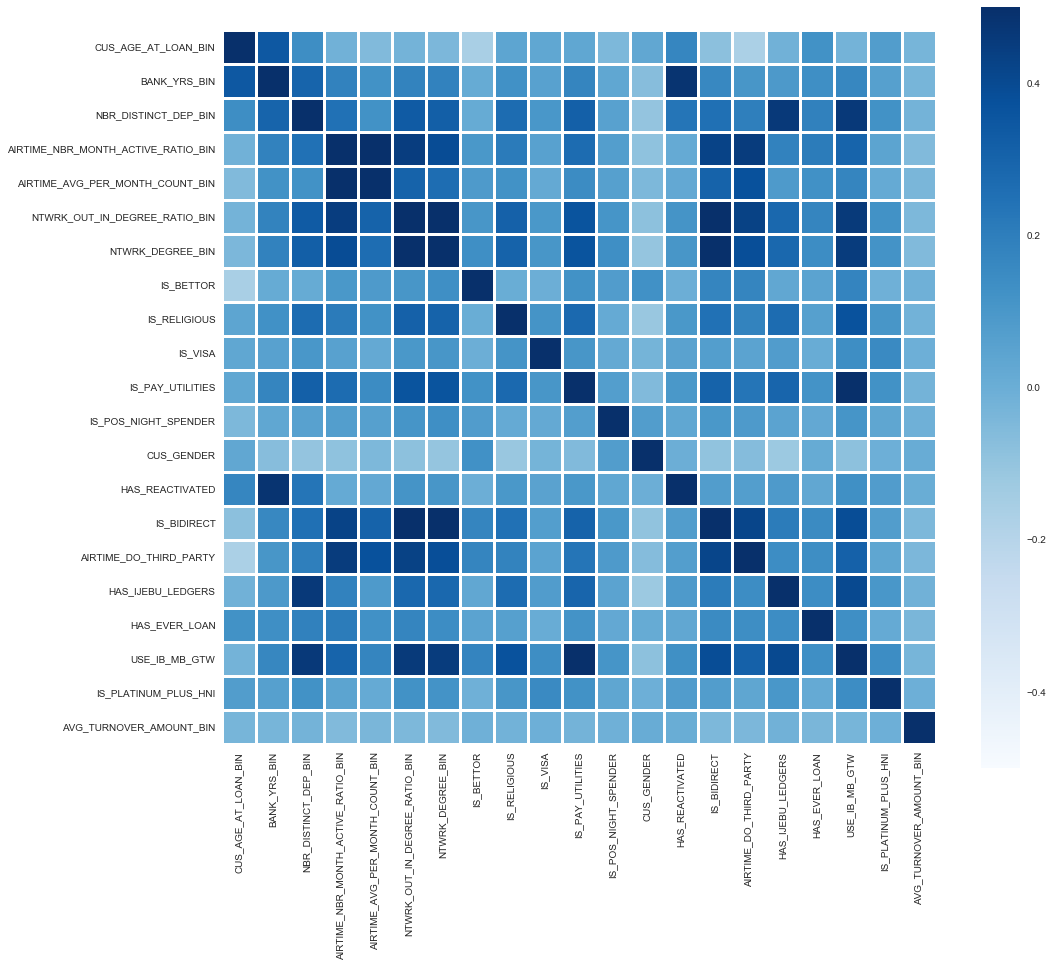

In [12]:
corr = dataset[cols_selected].corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0, square=True, linewidths=2, cmap='Blues')
# plt.savefig("heatmap.png")
plt.show()

###### re-sampling of Imbalanced dataset

In [13]:
samplingTechnique = None

if samplingTechnique=='under':
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_sample(X_train_original, y_train_original)
    print('Training Set Shape after undersampling: ', X_train.shape, y_train.shape)
elif samplingTechnique=='over':
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_sample(X_train_original, y_train_original)
    print('Training Set Shape after oversampling: ', X_train.shape, y_train.shape)
else:
    X_train = X_train_original
    y_train = y_train_original
    

In [14]:
# check
print 'frequency table of original data outcome'
print '-----------------------------------------'
print pd.Series(y_train_original.flatten()).value_counts()
print '\nfrequency table of oversampled/undersampled data outcome'
print '---------------------------------------------'
print pd.Series(y_train.flatten()).value_counts()

frequency table of original data outcome
-----------------------------------------
0.0    6120
1.0    6116
dtype: int64

frequency table of oversampled/undersampled data outcome
---------------------------------------------
0.0    6120
1.0    6116
dtype: int64


### Build Models

###### Decision Tree Classifier

In [15]:
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [16]:
clf_DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, 
                                min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features=None, 
                                max_leaf_nodes=None, min_impurity_split=1e-07, random_state=42)
clf_DT.fit(X_train, y_train)

# write the model to disk
pickle.dump(clf_DT, open('clf_DT.sav', 'wb'))
y_pred_DT = clf_DT.predict(X_val)

###### Naive Bayes Classifier

In [17]:
clf_NB = BernoulliNB()
clf_NB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_NB, open('clf_NB.sav', 'wb'))
y_pred_NB = clf_NB.predict(X_val)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###### Neural Network Classifier

In [18]:
MLPClassifier(activation='relu', alpha=1e-05,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=True,
       warm_start=False)
clf_MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64))

clf_MLP.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_MLP, open('clf_MLP.sav', 'wb'))
y_pred_MLP = clf_MLP.predict(X_val)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###### Logistic Regression Classifier

In [19]:
#clf_Log = LogisticRegression(solver='sag', max_iter=1000, random_state=42,verbose=2)
clf_Log = LogisticRegression(solver='liblinear', max_iter=1000, 
                             random_state=42,verbose=2,class_weight='balanced')

clf_Log.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_Log, open('clf_Log.sav', 'wb'))
y_pred_Log = clf_Log.predict(X_val)
print(clf_Log.coef_)
print(clf_Log.intercept_)

[LibLinear][[-0.25198988 -0.1766739  -0.37607086 -0.18214706  0.07834958 -0.09533117
   0.03396099  0.33120023 -0.17491083  0.26748408 -0.18086028  0.22205105
   0.53874483  0.41566319  0.096445    0.25738415 -0.67920259 -0.51184215
  -0.31502538 -0.33971225  0.5258371 ]]
[-0.00607068]


###### Random Forest Classifier

In [20]:
clf_RF = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=15,
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, 
                                bootstrap=True, oob_score=False, n_jobs=1, 
                                random_state=42, verbose=1, warm_start=False, class_weight=None)
clf_RF.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_RF, open('clf_RF.sav', 'wb'))
y_pred_RF = clf_RF.predict(X_val)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished


###### AdaBoost Classifier

In [21]:
clf_AdaB = AdaBoostClassifier(n_estimators=100)
clf_AdaB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_AdaB, open('clf_AdaB.sav', 'wb'))
y_pred_AdaB = clf_AdaB.predict(X_val)

###### Gradient Boost Classifier

In [22]:
clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
clf_GB.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_GB, open('clf_GB.sav', 'wb'))
y_pred_GB = clf_GB.predict(X_val)

###### Extra Tree Classifier

In [23]:
clf_ET = ExtraTreesClassifier(n_estimators=250, random_state=42)
clf_ET.fit(X_train, y_train)
# write the model to disk
pickle.dump(clf_ET, open('clf_ET.sav', 'wb'))
y_pred_ET = clf_ET.predict(X_val)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


###### SVM Classifier

In [24]:
# clf_SVM = SVC(C=10, class_weight='balanced', gamma='auto', kernel='rbf',
#               max_iter=-1, probability=True, random_state=42, verbose=True)
# clf_SVM.fit(X_train, y_train)
# y_pred_SVM = clf_SVM.predict(X_val)

In [25]:
y_val = y_val.reshape(-1)

### Model Performance Comparison

###### Compare Accuracy of Models on Validation Set

In [26]:
print('       Accuracy of Models for Validation Set       ')
print('--------------------------------')
print('Decision Tree           '+"{:.2f}".format(accuracy_score(y_val, y_pred_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(accuracy_score(y_val, y_pred_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(accuracy_score(y_val, y_pred_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(accuracy_score(y_val, y_pred_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(accuracy_score(y_val, y_pred_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(accuracy_score(y_val, y_pred_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(accuracy_score(y_val, y_pred_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(accuracy_score(y_val, y_pred_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(accuracy_score(y_val, y_pred_SVM)*100)+'%')

       Accuracy of Models for Validation Set       
--------------------------------
Decision Tree           66.18%
Naive Bayes             63.11%
Neural Network          68.57%
Logistic Regression     66.67%
Random Forest           67.46%
AdaBoost                67.41%
GradientBoost           66.89%
Extra Tree              63.48%


###### Compare Precision of Models on Validation Set

In [27]:
print('       Precision of Models  for Validation Set     ')
print('---------------------------------')
print('Decision Tree           '+"{:.2f}".format(precision_score(y_val, y_pred_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(precision_score(y_val, y_pred_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(precision_score(y_val, y_pred_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(precision_score(y_val, y_pred_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(precision_score(y_val, y_pred_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(precision_score(y_val, y_pred_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(precision_score(y_val, y_pred_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(precision_score(y_val, y_pred_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(precision_score(y_val, y_pred_SVM)*100)+'%')

       Precision of Models  for Validation Set     
---------------------------------
Decision Tree           65.78%
Naive Bayes             61.64%
Neural Network          66.31%
Logistic Regression     65.59%
Random Forest           66.13%
AdaBoost                66.31%
GradientBoost           65.63%
Extra Tree              63.01%


###### Compare True Positive Rate/Recall of Models on Validation Set

In [28]:
print('       Recall of Models    for Validation Set    ')
print('---------------------------------')
print('Decision Tree           '+"{:.2f}".format(recall_score(y_val, y_pred_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(recall_score(y_val, y_pred_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(recall_score(y_val, y_pred_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(recall_score(y_val, y_pred_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(recall_score(y_val, y_pred_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(recall_score(y_val, y_pred_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(recall_score(y_val, y_pred_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(recall_score(y_val, y_pred_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(recall_score(y_val, y_pred_SVM)*100)+'%')

       Recall of Models    for Validation Set    
---------------------------------
Decision Tree           66.76%
Naive Bayes             68.48%
Neural Network          74.89%
Logistic Regression     69.45%
Random Forest           70.94%
AdaBoost                70.14%
GradientBoost           70.25%
Extra Tree              64.42%


###### Print Confusion Matrix for all Models

In [29]:
print('Decision Tree  ')
cm_DT = confusion_matrix(y_val,y_pred_DT)
print(cm_DT)
print('\n')

print('Naive Bayes  ')
cm_NB = confusion_matrix(y_val,y_pred_NB)
print(cm_NB)
print('\n')

print('Neural Network  ')
cm_MLP = confusion_matrix(y_val,y_pred_MLP)
print(cm_MLP)
print('\n')

print('Logistic Regression  ')
cm_Log = confusion_matrix(y_val,y_pred_Log)
print(cm_Log)
print('\n')

print('Random Forest  ')
cm_RF = confusion_matrix(y_val,y_pred_RF)
print(cm_RF)
print('\n')

print('AdaBoost  ')
cm_AdaB = confusion_matrix(y_val,y_pred_AdaB)
print(cm_AdaB)
print('\n')

print('GradientBoost  ')
cm_GB = confusion_matrix(y_val,y_pred_GB)
print(cm_GB)
print('\n')

print('Extra Tree  ')
cm_ET = confusion_matrix(y_val,y_pred_ET)
print(cm_ET)
print('\n')

# print('SVM  ')
# cm_SVM = confusion_matrix(y_val,y_pred_SVM)
# print(cm_SVM)

Decision Tree  
[[1158  607]
 [ 581 1167]]


Naive Bayes  
[[1020  745]
 [ 551 1197]]


Neural Network  
[[1100  665]
 [ 439 1309]]


Logistic Regression  
[[1128  637]
 [ 534 1214]]


Random Forest  
[[1130  635]
 [ 508 1240]]


AdaBoost  
[[1142  623]
 [ 522 1226]]


GradientBoost  
[[1122  643]
 [ 520 1228]]


Extra Tree  
[[1104  661]
 [ 622 1126]]




### Test Set Results

###### Compare Models on Training, Validation and Test Set Results`

###### Execute only on Final Run

In [30]:
Final_Run=True

if Final_Run:
    y_test = y_test.reshape(-1)
    y_train_original = y_train_original.reshape(-1)
    # Predict training dataset
    y_pred_train_DT = clf_DT.predict(X_train_original)
    y_pred_train_NB = clf_NB.predict(X_train_original)
    y_pred_train_MLP = clf_MLP.predict(X_train_original)
    y_pred_train_Log = clf_Log.predict(X_train_original)
    y_pred_train_RF = clf_RF.predict(X_train_original)
    y_pred_train_AdaB = clf_AdaB.predict(X_train_original)
    y_pred_train_GB = clf_GB.predict(X_train_original)
    y_pred_train_ET = clf_ET.predict(X_train_original)
#     y_pred_train_SVM = clf_SVM.predict(X_train_original)
    # Predict test dataset
    y_pred_test_DT = clf_DT.predict(X_test)
    y_pred_test_NB = clf_NB.predict(X_test)
    y_pred_test_MLP = clf_MLP.predict(X_test)
    y_pred_test_Log = clf_Log.predict(X_test)
    y_pred_test_RF = clf_RF.predict(X_test)
    y_pred_test_AdaB = clf_AdaB.predict(X_test)
    y_pred_test_GB = clf_GB.predict(X_test)
    y_pred_test_ET = clf_ET.predict(X_test)
#     y_pred_test_SVM = clf_SVM.predict(X_test)
    # get confusion matrix for training dataset
    cm_DT_train = confusion_matrix(y_train_original,y_pred_train_DT)
    cm_NB_train = confusion_matrix(y_train_original,y_pred_train_NB)
    cm_MLP_train = confusion_matrix(y_train_original,y_pred_train_MLP)
    cm_Log_train = confusion_matrix(y_train_original,y_pred_train_Log)
    cm_RF_train = confusion_matrix(y_train_original,y_pred_train_RF)
    cm_AdaB_train = confusion_matrix(y_train_original,y_pred_train_AdaB)
    cm_GB_train = confusion_matrix(y_train_original,y_pred_train_GB)
    cm_ET_train = confusion_matrix(y_train_original,y_pred_train_ET)
#     cm_SVM_train = confusion_matrix(y_train_original,y_pred_train_SVM)
    # get confusion matrix for test dataset
    cm_DT_test = confusion_matrix(y_test,y_pred_test_DT)
    cm_NB_test = confusion_matrix(y_test,y_pred_test_NB)
    cm_MLP_test = confusion_matrix(y_test,y_pred_test_MLP)
    cm_Log_test = confusion_matrix(y_test,y_pred_test_Log)
    cm_RF_test = confusion_matrix(y_test,y_pred_test_RF)
    cm_AdaB_test = confusion_matrix(y_test,y_pred_test_AdaB)
    cm_GB_test = confusion_matrix(y_test,y_pred_test_GB)
    cm_ET_test = confusion_matrix(y_test,y_pred_test_ET)
#     cm_SVM_test = confusion_matrix(y_test,y_pred_test_SVM)

    print('Decision Tree Classification Matrix  ')
    print('Training')
    print(cm_DT_train)
    print('Validation')
    print(cm_DT)
    print('Test')
    print(cm_DT_test)
    print('\n')

    print('Naive Bayes Classification Matrix ')
    print('Training')
    print(cm_NB_train)
    print('Validation')
    print(cm_NB)
    print('Test')
    print(cm_NB_test)
    print('\n')

    print('Neural Network Classification Matrix ')
    print('Training')
    print(cm_MLP_train)
    print('Validation')
    print(cm_MLP)
    print('Test')
    print(cm_MLP_test)
    print('\n')

    print('Logistic Regression Classification Matrix ')
    print('Training')
    print(cm_Log_train)
    print('Validation')
    print(cm_Log)
    print('Test')
    print(cm_Log_test)
    print('\n')
    
    print('Random Forest Classification Matrix ')
    print('Training')
    print(cm_RF_train)
    print('Validation')
    print(cm_RF)
    print('Test')
    print(cm_RF_test)
    print('\n')
    
    print('AdaBoost Classification Matrix ')
    print('Training')
    print(cm_AdaB_train)
    print('Validation')
    print(cm_AdaB)
    print('Test')
    print(cm_AdaB_test)
    print('\n')
    
    print('GradientBoost Classification Matrix ')
    print('Training')
    print(cm_GB_train)
    print('Validation')
    print(cm_GB)
    print('Test')
    print(cm_GB_test)
    print('\n')
    
    print('Extra Tree Classification Matrix ')
    print('Training')
    print(cm_ET_train)
    print('Validation')
    print(cm_ET)
    print('Test')
    print(cm_ET_test)
    print('\n')
    
#     print('SVM Classification Matrix ')
#     print('Training')
#     print(cm_SVM_train)
#     print('Validation')
#     print(cm_SVM)
#     print('Test')
#     print(cm_SVM_test)
#     print('\n')

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished


Decision Tree Classification Matrix  
Training
[[4358 1762]
 [1627 4489]]
Validation
[[1158  607]
 [ 581 1167]]
Test
[[521 334]
 [288 588]]


Naive Bayes Classification Matrix 
Training
[[3521 2599]
 [2070 4046]]
Validation
[[1020  745]
 [ 551 1197]]
Test
[[474 381]
 [266 610]]


Neural Network Classification Matrix 
Training
[[3727 2393]
 [1510 4606]]
Validation
[[1100  665]
 [ 439 1309]]
Test
[[493 362]
 [214 662]]


Logistic Regression Classification Matrix 
Training
[[3831 2289]
 [1920 4196]]
Validation
[[1128  637]
 [ 534 1214]]
Test
[[534 321]
 [263 613]]


Random Forest Classification Matrix 
Training
[[5180  940]
 [ 427 5689]]
Validation
[[1130  635]
 [ 508 1240]]
Test
[[494 361]
 [255 621]]


AdaBoost Classification Matrix 
Training
[[3894 2226]
 [1923 4193]]
Validation
[[1142  623]
 [ 522 1226]]
Test
[[522 333]
 [251 625]]


GradientBoost Classification Matrix 
Training
[[4047 2073]
 [1527 4589]]
Validation
[[1122  643]
 [ 520 1228]]
Test
[[526 329]
 [262 614]]


Extra Tree C

In [31]:
print('       Recall of Models - Training ds      ')
print('-------------------------------------------')
print('Decision Tree           '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(recall_score(y_train_original, y_pred_train_SVM)*100)+'%')

       Recall of Models - Training ds      
-------------------------------------------
Decision Tree           73.40%
Naive Bayes             66.15%
Neural Network          75.31%
Logistic Regression     68.61%
Random Forest           93.02%
AdaBoost                68.56%
GradientBoost           75.03%
Extra Tree              93.43%


In [32]:
print('       Recall of Models - Test ds      ')
print('---------------------------------------')
print('Decision Tree           '+"{:.2f}".format(recall_score(y_test, y_pred_test_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(recall_score(y_test, y_pred_test_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(recall_score(y_test, y_pred_test_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(recall_score(y_test, y_pred_test_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(recall_score(y_test, y_pred_test_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(recall_score(y_test, y_pred_test_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(recall_score(y_test, y_pred_test_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(recall_score(y_test, y_pred_test_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(recall_score(y_test, y_pred_test_SVM)*100)+'%')

       Recall of Models - Test ds      
---------------------------------------
Decision Tree           67.12%
Naive Bayes             69.63%
Neural Network          75.57%
Logistic Regression     69.98%
Random Forest           70.89%
AdaBoost                71.35%
GradientBoost           70.09%
Extra Tree              67.69%


In [33]:
print('       Recall of Models - Validation ds      ')
print('---------------------------------------------')
print('Decision Tree           '+"{:.2f}".format(recall_score(y_val, y_pred_DT)*100)+'%')
print('Naive Bayes             '+"{:.2f}".format(recall_score(y_val, y_pred_NB)*100)+'%')
print('Neural Network          '+"{:.2f}".format(recall_score(y_val, y_pred_MLP)*100)+'%')
print('Logistic Regression     '+"{:.2f}".format(recall_score(y_val, y_pred_Log)*100)+'%')
print('Random Forest           '+"{:.2f}".format(recall_score(y_val, y_pred_RF)*100)+'%')
print('AdaBoost                '+"{:.2f}".format(recall_score(y_val, y_pred_AdaB)*100)+'%')
print('GradientBoost           '+"{:.2f}".format(recall_score(y_val, y_pred_GB)*100)+'%')
print('Extra Tree              '+"{:.2f}".format(recall_score(y_val, y_pred_ET)*100)+'%')
# print('Support Vector Machine  '+"{:.2f}".format(recall_score(y_val, y_pred_SVM)*100)+'%')

       Recall of Models - Validation ds      
---------------------------------------------
Decision Tree           66.76%
Naive Bayes             68.48%
Neural Network          74.89%
Logistic Regression     69.45%
Random Forest           70.94%
AdaBoost                70.14%
GradientBoost           70.25%
Extra Tree              64.42%


In [34]:
confusion_matrx_val=comb_conf_mtx('Validation', ('Decision Tree',cm_DT), ('Naive Bayes',cm_NB), ('Neural Network',cm_MLP), ('Logistic Regression',cm_Log),
             ('Random Forest',cm_RF), ('Ada Boost',cm_AdaB), ('Gradient Boost',cm_GB), ('Extra Tree',cm_ET))#, ('SVM',cm_SVM))
confusion_matrx_train=comb_conf_mtx('Training', ('Decision Tree',cm_DT_train), ('Naive Bayes',cm_NB_train), ('Neural Network',cm_MLP_train), ('Logistic Regression',cm_Log_train),
             ('Random Forest',cm_RF_train), ('Ada Boost',cm_AdaB_train), ('Gradient Boost',cm_GB_train), ('Extra Tree',cm_ET_train)) #, ('SVM',cm_SVM_train))
confusion_matrx_test=comb_conf_mtx('Testing', ('Decision Tree',cm_DT_test), ('Naive Bayes',cm_NB_test), ('Neural Network',cm_MLP_test), ('Logistic Regression',cm_Log_test),
             ('Random Forest',cm_RF_test), ('Ada Boost',cm_AdaB_test), ('Gradient Boost',cm_GB_test), ('Extra Tree',cm_ET_test))#, ('SVM',cm_SVM_test))

confusion_matrices = pd.concat([confusion_matrx_val,confusion_matrx_train,confusion_matrx_test])
confusion_matrices.to_csv('confusion_matrices.csv')


In [35]:
# calculate and print score metrics per dataset type
# remove empty rows from dataframe
confusion_matrices_df=confusion_matrices[~pd.isnull(confusion_matrices['Dataset type'])]
for ds_type in confusion_matrices_df['Dataset type'].unique():
    cur_df_cm = confusion_matrices_df[confusion_matrices_df['Dataset type']==ds_type]
    cur_df_result=pd.DataFrame()

    for md_type in cur_df_cm['Model type'].unique():
        cur_df_cm_md = cur_df_cm[cur_df_cm['Model type']==md_type]
        
        tn=cur_df_cm_md.iloc[0,0]
        fn=cur_df_cm_md.iloc[1,0]
        fp=cur_df_cm_md.iloc[0,1]
        tp=cur_df_cm_md.iloc[1,1]
        tot_n_p=tn+fn+fp+tp
        
        format_pattern='{:.0%}'
        # Accuracy
        cur_df_result.loc[md_type, 'accuracy']='{}'.format(format_pattern).format((tp+tn)/tot_n_p)
        # Misclassification Rate (Error Rate)
        cur_df_result.loc[md_type, 'Misclassification Rate (Error Rate)']='{}'.format(format_pattern).format((fp+fn)/tot_n_p)
        # True Positive Rate
        cur_df_result.loc[md_type, 'True Positive Rate']='{}'.format(format_pattern).format((tp)/(tp+fn))
        # False Positive Rate
        cur_df_result.loc[md_type, 'False Positive Rate']='{}'.format(format_pattern).format((fp)/(tn+fp))
        # Specificity
        cur_df_result.loc[md_type, 'Specificity']='{}'.format(format_pattern).format((tn)/(tn+fp))
        # Precision
        cur_df_result.loc[md_type, 'Precision']='{}'.format(format_pattern).format((tp)/(tp+fp))
        # Prevalence
        cur_df_result.loc[md_type, 'Prevalence']='{}'.format(format_pattern).format((fn+tp)/tot_n_p)
        # Positive predictive value
        cur_df_result.loc[md_type, 'Positive predictive value']='{}'.format(format_pattern).format((tp)/(fp+tp))
        # Negative predictive value
        cur_df_result.loc[md_type, 'Negative predictive value']='{}'.format(format_pattern).format((fp)/(fp+tp))

    cur_df_result=cur_df_result.T
    cur_df_result.to_csv(ds_type+'_score_sheet.csv')
    


#### Final

In [36]:
y_pred_DT_proba = clf_DT.predict_proba(X)
y_pred_NB_proba = clf_NB.predict_proba(X)
y_pred_MLP_proba = clf_MLP.predict_proba(X)
y_pred_Log_proba = clf_Log.predict_proba(X)
y_pred_RF_proba = clf_RF.predict_proba(X)
y_pred_AdaB_proba = clf_AdaB.predict_proba(X)
y_pred_GB_proba = clf_GB.predict_proba(X)
y_pred_ET_proba = clf_ET.predict_proba(X)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.9s finished


In [37]:
dataset['y_pred_DT_proba']=[i[1] for i in y_pred_DT_proba]
dataset['y_pred_NB_proba']=[i[1] for i in y_pred_NB_proba]
dataset['y_pred_MLP_proba']=[i[1] for i in y_pred_MLP_proba]
dataset['y_pred_Log_proba']=[i[1] for i in y_pred_Log_proba]
dataset['y_pred_RF_proba']=[i[1] for i in y_pred_RF_proba]
dataset['y_pred_AdaB_proba']=[i[1] for i in y_pred_AdaB_proba]
dataset['y_pred_GB_proba']=[i[1] for i in y_pred_GB_proba]
dataset['y_pred_ET_proba']=[i[1] for i in y_pred_ET_proba]

### Write to db

In [38]:
dataset.to_csv('sampled_final_set_after_model.csv', index = False)

In [39]:
dataset.columns = dataset.columns.str.upper()

In [40]:
dataset.columns = [c[:30] for c in dataset.columns]

In [41]:
import sqlalchemy
conn = sqlalchemy.create_engine('oracle+cx_oracle://{}:{}@dwdrscan.gtbank.com:1521/?service_name=odidb'
                                .format(un, pwd))
dataset.to_sql(db_table_nm, conn, index=False, if_exists='replace', chunksize=10000, dtype=db_utils.sqlcol(dataset))

### Features importance 

In [42]:
importances_RF = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
# indices1 = np.argsort(importances_RF[0:var])[::-1]
indices1 = np.argsort(importances_RF)[::-1]

indices = indices1
# indices = indices1[0:var]
# Print the feature ranking
print("Feature ranking:")
features_ranking=pd.DataFrame(columns=['FEATURE','IMPORTANCE'])
var=len(cols_selected)
for f in range(var):
    features_ranking=features_ranking.append({
        features_ranking.columns[0]:cols_selected[indices[f]],
        features_ranking.columns[1]:importances_RF[indices[f]]
    }, ignore_index=True)
    print("%d. %s (%f)" % (f + 1, cols_selected[indices[f]], importances_RF[indices[f]]))
print("%d. %s (%f)" % (f + 1, (dataset.columns.values).reshape(-1)[indices[f]], importances_RF[indices[f]]))
features_ranking.to_csv('features_ranking_based_on_randomforest.csv', index=False)



Feature ranking:
1. CUS_AGE_AT_LOAN_BIN (0.103824)
2. BANK_YRS_BIN (0.098803)
3. AIRTIME_AVG_PER_MONTH_COUNT_BIN (0.098073)
4. NTWRK_OUT_IN_DEGREE_RATIO_BIN (0.089734)
5. NTWRK_DEGREE_BIN (0.081546)
6. AIRTIME_NBR_MONTH_ACTIVE_RATIO_BIN (0.071751)
7. NBR_DISTINCT_DEP_BIN (0.055604)
8. HAS_EVER_LOAN (0.052832)
9. HAS_REACTIVATED (0.042162)
10. USE_IB_MB_GTW (0.040906)
11. CUS_GENDER (0.037142)
12. IS_BETTOR (0.037138)
13. IS_RELIGIOUS (0.034751)
14. IS_PAY_UTILITIES (0.031360)
15. AIRTIME_DO_THIRD_PARTY (0.029239)
16. IS_BIDIRECT (0.028684)
17. HAS_IJEBU_LEDGERS (0.028453)
18. IS_POS_NIGHT_SPENDER (0.027817)
19. IS_PLATINUM_PLUS_HNI (0.004368)
20. IS_VISA (0.004195)
21. AVG_TURNOVER_AMOUNT_BIN (0.001618)
21. USE_IB_MB_GTW (0.001618)
